In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
nltk.download('stopwords')
nltk.download('wordnet')
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from matplotlib import colors
from wordcloud import WordCloud
from scipy.sparse import hstack, csr_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_data = pd.read_csv('/content/shuffled_train_data.csv',index_col=None)
train_labels = pd.read_csv('/content/shuffled_train_labels.csv',index_col=None)

test_data = pd.read_csv('/content/test_data.csv',index_col=None)
test_labels = pd.read_csv('/content/test_labels.csv',index_col=None)

val_data = pd.read_csv('/content/validation_data.csv',index_col=None)
val_labels = pd.read_csv('/content/validation_labels.csv',index_col=None)

train_data.shape

(45000, 1)

In [ ]:
train_labels.rename(columns={'0': "label"}, inplace=True)
print(train_labels.columns)

Index(['label'], dtype='object')


In [ ]:
def assign_values(row):
    if row['categorie_negative']:
        return 0
    elif row['categorie_positive']:
        return 2
    else:
        return 1

In [ ]:
y=list(train_labels['label'])
y = pd.get_dummies(y,prefix='categorie')
y['valoare'] = y.apply(assign_values, axis=1)

In [ ]:
y_test=list(test_labels['label'])
y_test = pd.get_dummies(y_test,prefix='categorie')
y_test['valoare'] = y_test.apply(assign_values, axis=1)

In [ ]:
y_val=list(val_labels['label'])
y_val = pd.get_dummies(y_val,prefix='categorie')
y_val['valoare'] = y_val.apply(assign_values, axis=1)

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [ ]:
train_encodings = tokenizer(list(train_data['0']), truncation=True, padding="max_length")

In [ ]:
val_encodings = tokenizer(list(val_data['text']), truncation=True, padding=True)


In [ ]:
test_encodings = tokenizer(list(test_data['text']), truncation=True, padding=True)


In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y['valoare']
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test['valoare']
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val['valoare']
))

In [ ]:
from transformers import  TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments


In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                              num_labels=3)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate= 5e-5)

#compile the model
model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'])

#train the model
model.fit(train_dataset.shuffle(len(train_data)).batch(16),
              epochs=3,
              batch_size=16,
              validation_data=val_dataset.shuffle(len(val_data)).batch(16))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
2813/2813 [==============================] - 2795s 985ms/step - loss: 0.5849 - accuracy: 0.7451 - val_loss: 0.5796 - val_accuracy: 0.7292
Epoch 2/3
2813/2813 [==============================] - 2773s 986ms/step - loss: 0.4713 - accuracy: 0.7986 - val_loss: 0.5408 - val_accuracy: 0.7650
Epoch 3/3
2813/2813 [==============================] - 2770s 985ms/step - loss: 0.3767 - accuracy: 0.8442 - val_loss: 0.5800 - val_accuracy: 0.7688


In [ ]:
model.evaluate(test_dataset.shuffle(len(test_data)).batch(16),
               return_dict=True,
               batch_size=16)

375/375 [==============================] - 122s 324ms/step - loss: 0.5988 - accuracy: 0.7627


{'loss': 0.5987713932991028, 'accuracy': 0.762666642665863}

In [ ]:
predictions = model.predict(test_dataset)

6000/6000 [==============================] - 123s 20ms/step


In [ ]:
predictions

TFSequenceClassifierOutput(loss=None, logits=array([[ 2.4317822 ,  0.16415246, -3.8674984 ],
       [ 2.6867595 ,  0.01611967, -4.1222496 ],
       [ 2.3189614 ,  0.47553813, -4.0835743 ],
       ...,
       [ 0.7311436 ,  1.4101301 , -2.8250897 ],
       [-3.0140648 , -1.7599596 ,  4.357056  ],
       [-3.1627493 , -1.6659249 ,  4.3766937 ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
import numpy as np

# Calculează predicțiile finale
predicted_labels = np.argmax(predictions.logits, axis=1)

predicted_labels

array([0, 0, 0, ..., 1, 2, 2])

In [ ]:
# Calculează acuratețea
accuracy = np.mean(np.equal(y_test['valoare'], predicted_labels))
print("Accuracy on validation set:", accuracy)
from sklearn.metrics import classification_report

print(classification_report(y_test['valoare'], predicted_labels))


Accuracy on validation set: 0.7626666666666667
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      2250
           1       0.58      0.49      0.53      1500
           2       0.87      0.89      0.88      2250

    accuracy                           0.76      6000
   macro avg       0.73      0.73      0.73      6000
weighted avg       0.75      0.76      0.76      6000



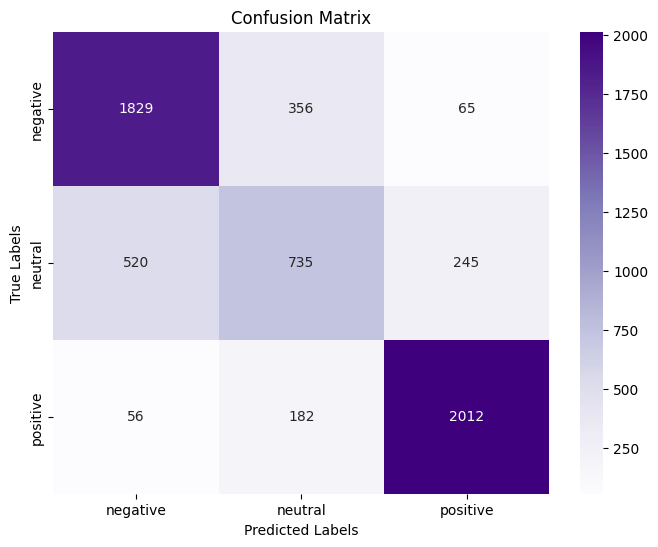

In [ ]:
predicted_labels = np.argmax(predictions.logits, axis=1)

import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test['valoare'], predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels = ['negative', 'neutral', 'positive'], yticklabels = ['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()